## Set Up

In [1]:
import pandas as pd
import calendar
import datetime

## Import Data

In [2]:
# Create function to import multiple data files

data_path = "http://web.mta.info/developers/data/nyct/turnstile/turnstile_"

def import_data(date):
    """
    import data
    clean column names
    """
    dfname = pd.read_csv(data_path+date+".txt")
    dfname.columns = dfname.columns.str.strip()
    return dfname
          
mta190504_raw = import_data("190504")
mta190511_raw = import_data("190511")
mta190518_raw = import_data("190518")
mta190525_raw = import_data("190525")
mta190601_raw = import_data("190601")


In [3]:
# Concatenate all data
frames = [mta190504_raw, mta190511_raw, mta190518_raw, mta190525_raw, mta190601_raw]

mta19_raw = pd.concat(frames).reset_index().drop(["index"], axis=1)

mta19_raw.info()
mta19_raw.describe()
#mta19_raw.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1026784 entries, 0 to 1026783
Data columns (total 11 columns):
C/A         1026784 non-null object
UNIT        1026784 non-null object
SCP         1026784 non-null object
STATION     1026784 non-null object
LINENAME    1026784 non-null object
DIVISION    1026784 non-null object
DATE        1026784 non-null object
TIME        1026784 non-null object
DESC        1026784 non-null object
ENTRIES     1026784 non-null int64
EXITS       1026784 non-null int64
dtypes: int64(2), object(9)
memory usage: 86.2+ MB


,ENTRIES,EXITS
count,1.026784e+06,1.026784e+06
mean,4.154868e+07,3.402282e+07
std,2.116724e+08,1.949751e+08
min,0.000000e+00,0.000000e+00
25%,3.525555e+05,1.442150e+05
50%,2.174353e+06,1.245738e+06
75%,6.789071e+06,4.603742e+06
max,2.129343e+09,2.124127e+09


In [19]:
def time_interval(x):
    if x in [0,1,2,3]:
        return "20:00-23:59"
    elif x in [4,5,6,7]:
        return "00:00-03:59"
    elif x in [8,9,10,11]:
        return "04:00-07:59"
    elif x in [12,13,14,15]:
        return "08:00-11:59"
    elif x in [16,17,18,19]:
        return "12:00-15:59"
    elif x in [20,21,22,23]:
        return "16:00-19:59"

In [20]:
# Add and format new variables

def data_clean(dfname):
    """
    add and format new variables
    """
    dfname2 = dfname.copy()
    # Create variables:
    # "time_hour" that simplifies the hour for later grouping purposes
    dfname2["time_hour"] = pd.to_numeric(dfname2["TIME"].str[0:2])
    # formatted date variable "DDATE"
    dfname2['DDATE']=[datetime.datetime.strptime(x, '%m/%d/%Y') for x in dfname2['DATE']]
    # formatted time variable "DTIME"
    dfname2['DTIME']=[datetime.datetime.strptime(x, '%H:%M:%S') for x in dfname2['TIME']]
    dfname2['DDATETIME'] = pd.to_datetime(dfname2['DATE']+" "+dfname2['TIME'])
    dfname2['DDATETIME2'] = dfname2['DDATETIME'] - datetime.timedelta(seconds=1)
    dfname2['DTIME']=[format(x,"%H:%M:%S") for x in dfname2['DTIME']]
    # formatted day of the week variable "DDAY"
    dfname2['DDAY']=[calendar.day_name[datetime.datetime.weekday(x)] for x in dfname2['DDATE']]
    # create time period category "time_cat"
    dfname2["time_cat"] = dfname2["time_hour"].apply(time_interval)
    
    #INVESTIGATION
#     dfname2["time_cat2"] = dfname2["time_hour2"].apply(time_interval)
#     dfname2['new_date'] = dfname2['DDATETIME2'] - datetime.timedelta(seconds=1)
#     dfname2['new_time'] = dfname2['DDATETIME'] - datetime.timedelta(seconds=1)
#     dfname2["time_hour2"] = pd.to_numeric(dfname2["TIME"].str[0:2])
    
    # Sort before grouping for difference calculating
    dfname2.sort_values(["C/A","UNIT","SCP","STATION","LINENAME","DIVISION","DATE","TIME","DESC"], inplace = True)
    # Create difference columns to calculate difference in entries and exits between the row and the row before (aka the time before)
    dfname2["entries_diff"] = dfname2.groupby(["C/A","UNIT","SCP","STATION","LINENAME","DIVISION"]).ENTRIES.diff()
    dfname2["exits_diff"] = dfname2.groupby(["C/A","UNIT","SCP","STATION","LINENAME","DIVISION"]).EXITS.diff()
    dfname2["entries-exits"] = dfname2["entries_diff"] - dfname2["exits_diff"]
    dfname2["entries+exits"] = dfname2["entries_diff"] + dfname2["exits_diff"]
    
    # PLACEHOLDER Create better flag for suspiciously high differences in exits and entries diff
    
    #keep only rows with positive entries_diff, exits_diff, and ENTRIES
    dfname2= dfname2[dfname2.entries_diff > 0]
    dfname2 = dfname2[dfname2.exits_diff > 0]
    dfname2 = dfname2[dfname2.ENTRIES > 0]
    # dropping turnstile 00-04-00 at 23rd st due to data anomaly
    dfname2 = dfname2[(dfname2["STATION"] != "TWENTY THIRD ST") & (dfname2["SCP"] != "00-04-00")]
    # exclude high entries and exits that are likely a result of a terminal reset
    dfname2 = dfname2[dfname2.entries_diff < 100000]
    dfname2 = dfname2[dfname2.exits_diff < 100000].reset_index().drop(["index"],axis=1)
    #dfname2 = dfname2[dfname2.entries_diff < 10**7]
    #dfname2 = dfname2[dfname2.exits_diff < 10**7].reset_index().drop(["index"],axis=1)
    return dfname2

mta19 = data_clean(mta19_raw)
#data_clean(mta18_raw, mta18)
#etc. - can run it for multiple years

In [21]:
mta19.info()
mta19.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 833142 entries, 0 to 833141
Data columns (total 22 columns):
C/A              833142 non-null object
UNIT             833142 non-null object
SCP              833142 non-null object
STATION          833142 non-null object
LINENAME         833142 non-null object
DIVISION         833142 non-null object
DATE             833142 non-null object
TIME             833142 non-null object
DESC             833142 non-null object
ENTRIES          833142 non-null int64
EXITS            833142 non-null int64
time_hour        833142 non-null int64
DDATE            833142 non-null datetime64[ns]
DTIME            833142 non-null object
DDATETIME        833142 non-null datetime64[ns]
DDATETIME2       833142 non-null datetime64[ns]
DDAY             833142 non-null object
time_cat         833142 non-null object
entries_diff     833142 non-null float64
exits_diff       833142 non-null float64
entries-exits    833142 non-null float64
entries+exits    833142 n

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,...,DDATE,DTIME,DDATETIME,DDATETIME2,DDAY,time_cat,entries_diff,exits_diff,entries-exits,entries+exits
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,04/27/2019,04:00:00,REGULAR,7035269,...,2019-04-27,04:00:00,2019-04-27 04:00:00,2019-04-27 03:59:59,Saturday,00:00-03:59,20.0,7.0,13.0,27.0
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,04/27/2019,08:00:00,REGULAR,7035292,...,2019-04-27,08:00:00,2019-04-27 08:00:00,2019-04-27 07:59:59,Saturday,04:00-07:59,23.0,35.0,-12.0,58.0
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,04/27/2019,12:00:00,REGULAR,7035392,...,2019-04-27,12:00:00,2019-04-27 12:00:00,2019-04-27 11:59:59,Saturday,08:00-11:59,100.0,76.0,24.0,176.0
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,04/27/2019,16:00:00,REGULAR,7035651,...,2019-04-27,16:00:00,2019-04-27 16:00:00,2019-04-27 15:59:59,Saturday,12:00-15:59,259.0,69.0,190.0,328.0
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,04/27/2019,20:00:00,REGULAR,7035930,...,2019-04-27,20:00:00,2019-04-27 20:00:00,2019-04-27 19:59:59,Saturday,16:00-19:59,279.0,50.0,229.0,329.0
5,A002,R051,02-00-00,59 ST,NQR456W,BMT,04/28/2019,00:00:00,REGULAR,7036100,...,2019-04-28,00:00:00,2019-04-28 00:00:00,2019-04-27 23:59:59,Sunday,20:00-23:59,170.0,17.0,153.0,187.0
6,A002,R051,02-00-00,59 ST,NQR456W,BMT,04/28/2019,04:00:00,REGULAR,7036119,...,2019-04-28,04:00:00,2019-04-28 04:00:00,2019-04-28 03:59:59,Sunday,00:00-03:59,19.0,1.0,18.0,20.0
7,A002,R051,02-00-00,59 ST,NQR456W,BMT,04/28/2019,08:00:00,REGULAR,7036125,...,2019-04-28,08:00:00,2019-04-28 08:00:00,2019-04-28 07:59:59,Sunday,04:00-07:59,6.0,15.0,-9.0,21.0
8,A002,R051,02-00-00,59 ST,NQR456W,BMT,04/28/2019,12:00:00,REGULAR,7036197,...,2019-04-28,12:00:00,2019-04-28 12:00:00,2019-04-28 11:59:59,Sunday,08:00-11:59,72.0,52.0,20.0,124.0
9,A002,R051,02-00-00,59 ST,NQR456W,BMT,04/28/2019,16:00:00,REGULAR,7036372,...,2019-04-28,16:00:00,2019-04-28 16:00:00,2019-04-28 15:59:59,Sunday,12:00-15:59,175.0,43.0,132.0,218.0


In [15]:
mta19.describe()

,ENTRIES,EXITS,time_hour,entries_diff,exits_diff,entries-exits,entries+exits
count,8.331420e+05,8.331420e+05,833142.000000,833142.000000,833142.000000,833142.000000,833142.000000
mean,2.721228e+07,2.022876e+07,10.737138,208.139482,163.201786,44.937696,371.341267
std,1.587327e+08,1.345295e+08,6.818724,301.695093,281.079803,322.061688,486.135617
min,2.000000e+00,1.000000e+00,0.000000,1.000000,1.000000,-26406.000000,2.000000
25%,6.743255e+05,3.774022e+05,5.000000,31.000000,24.000000,-41.000000,82.000000
50%,2.813019e+06,1.660198e+06,12.000000,113.000000,78.000000,11.000000,242.000000
75%,7.058704e+06,5.032586e+06,16.000000,284.000000,200.000000,129.000000,524.000000
max,2.115843e+09,2.037865e+09,23.000000,73060.000000,51276.000000,37570.000000,108550.000000


In [33]:
import matplotlib.pyplot as plt
# You can configure the format of the images: ‘png’, ‘retina’, ‘jpeg’, ‘svg’, ‘pdf’.
%config InlineBackend.figure_format = 'svg'
# this statement allows the visuals to render within your Jupyter Notebook
%matplotlib inline 

In [24]:
# Group by station, day of week, and date
mta_station_day = mta19.groupby(["STATION","DDAY","DDATE"], as_index=False)[["entries_diff","exits_diff","entries+exits","entries-exits"]].sum().sort_values(["STATION","entries+exits"], ascending=False)
mta_station_day.head(10)

,STATION,DDAY,DDATE,entries_diff,exits_diff,entries+exits,entries-exits
13021,ZEREGA AV,Wednesday,2019-05-08,2931.0,2731.0,5662.0,200.0
13011,ZEREGA AV,Thursday,2019-05-09,2994.0,2625.0,5619.0,369.0
13020,ZEREGA AV,Wednesday,2019-05-01,2900.0,2700.0,5600.0,200.0
13023,ZEREGA AV,Wednesday,2019-05-22,2872.0,2700.0,5572.0,172.0
13024,ZEREGA AV,Wednesday,2019-05-29,2824.0,2736.0,5560.0,88.0
13014,ZEREGA AV,Thursday,2019-05-30,2829.0,2702.0,5531.0,127.0
13010,ZEREGA AV,Thursday,2019-05-02,2917.0,2582.0,5499.0,335.0
13016,ZEREGA AV,Tuesday,2019-05-07,2841.0,2640.0,5481.0,201.0
13017,ZEREGA AV,Tuesday,2019-05-14,2830.0,2639.0,5469.0,191.0
13018,ZEREGA AV,Tuesday,2019-05-21,2856.0,2611.0,5467.0,245.0


In [50]:
mta_station_dayavg = mta_station_day.groupby(["STATION"], as_index=False)[["entries_diff","exits_diff","entries+exits","entries-exits"]].mean().sort_values(["entries+exits"], ascending=[True])
mta_station_dayavg.tail(10)

,STATION,entries_diff,exits_diff,entries+exits,entries-exits
9,125 ST,66059.600000,56150.828571,122210.428571,9908.771429
110,86 ST,71457.914286,66353.828571,137811.742857,5104.085714
68,42 ST-PORT AUTH,80904.657143,69442.142857,150346.800000,11462.514286
225,FULTON ST,82502.371429,68961.314286,151463.685714,13541.057143
352,TIMES SQ-42 ST,87412.314286,81899.057143,169311.371429,5513.257143
46,23 ST,100188.857143,73164.457143,173353.314286,27024.400000
14,14 ST-UNION SQ,91151.800000,84337.457143,175489.257143,6814.342857
59,34 ST-HERALD SQ,100804.514286,95162.742857,195967.257143,5641.771429
232,GRD CNTRL-42 ST,124465.600000,107245.828571,231711.428571,17219.771429
61,34 ST-PENN STA,144831.428571,132091.971429,276923.400000,12739.457143


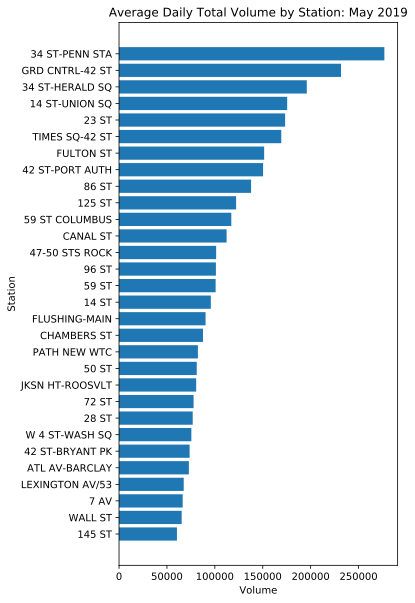

In [48]:
# GRAPH 1
#Plot graph of total volume
plt.figure(figsize = [5,10])
plt.barh(mta_station_dayavg["STATION"][-30:],mta_station_dayavg["entries+exits"][-30:])
plt.title("Average Daily Total Volume by Station: May 2019")
plt.ylabel("Station")
plt.xlabel("Volume");


In [85]:
def day_sort(x):
    if x == "Sunday":
        return 1
    elif x == "Monday":
        return 2
    elif x == "Tuesday":
        return 3
    elif x == "Wednesday":
        return 4
    elif x == "Thursday":
        return 5
    elif x == "Friday":
        return 6
    elif x == "Saturday":
        return 7

In [86]:
#GRAPH 2
mta_station_weekdayavg = mta_station_day.groupby(["STATION","DDAY"], as_index=False)[["entries_diff","exits_diff","entries+exits","entries-exits"]].mean().sort_values(["entries+exits"], ascending=[True])

mta_station_weekdayavg["day_sort"] = mta_station_weekdayavg["DDAY"].apply(day_sort)

mta_station_weekdayavg.head(10)

,STATION,DDAY,entries_diff,exits_diff,entries+exits,entries-exits,day_sort
2160,ORCHARD BEACH,Wednesday,1.000000,1.000000,2.000000,0.000000,4
2159,ORCHARD BEACH,Thursday,1.000000,2.000000,3.000000,-1.000000,5
2156,ORCHARD BEACH,Monday,1.000000,2.000000,3.000000,-1.000000,2
2158,ORCHARD BEACH,Sunday,10.000000,25.000000,35.000000,-15.000000,1
2403,ST. GEORGE,Thursday,33.500000,3.000000,36.500000,30.500000,5
2157,ORCHARD BEACH,Saturday,18.000000,24.000000,42.000000,-6.000000,7
2404,ST. GEORGE,Tuesday,42.000000,4.000000,46.000000,38.000000,3
2401,ST. GEORGE,Saturday,44.000000,2.750000,46.750000,41.250000,7
2400,ST. GEORGE,Monday,64.000000,3.666667,67.666667,60.333333,2
2402,ST. GEORGE,Sunday,71.333333,4.333333,75.666667,67.000000,1


In [87]:
mta_34PE= mta_station_weekdayavg[mta_station_weekdayavg['STATION'] =='34 ST-PENN STA' ].sort_values(['day_sort','DDAY', "entries+exits"], ascending=True)
mta_GC42= mta_station_weekdayavg[mta_station_weekdayavg['STATION'] =='GRD CNTRL-42 ST' ].sort_values(['day_sort','DDAY', "entries+exits"], ascending=True)
mta_34HE= mta_station_weekdayavg[mta_station_weekdayavg['STATION'] =='34 ST-HERALD SQ' ].sort_values(['day_sort','DDAY', "entries+exits"], ascending=True)
mta_14UN= mta_station_weekdayavg[mta_station_weekdayavg['STATION'] =='14 ST-UNION SQ' ].sort_values(['day_sort','DDAY', "entries+exits"], ascending=True)
mta_23ST= mta_station_weekdayavg[mta_station_weekdayavg['STATION'] =='23 ST' ].sort_values(['day_sort','DDAY', "entries+exits"], ascending=True)
mta_23ST

,STATION,DDAY,entries_diff,exits_diff,entries+exits,entries-exits,day_sort
325,23 ST,Sunday,45720.4,34786.0,80506.4,10934.4,1
323,23 ST,Monday,95396.6,71228.6,166625.2,24168.0,2
327,23 ST,Tuesday,122196.2,88331.6,210527.8,33864.6,3
328,23 ST,Wednesday,122101.6,83886.4,205988.0,38215.2,4
326,23 ST,Thursday,120578.4,84157.4,204735.8,36421.0,5
322,23 ST,Friday,111991.2,78363.0,190354.2,33628.2,6
324,23 ST,Saturday,83337.6,71398.2,154735.8,11939.4,7


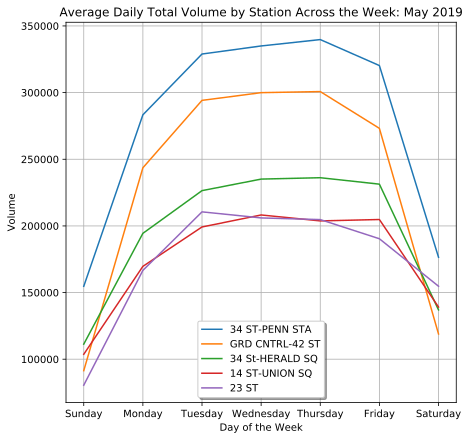

In [88]:

#figure canNOT be the (sum per day)/#time entries because the number time entries  taken per day is not the same
#therefore to inform on the traffic in the week, need to use full volume per day
#seems the WEDNESDAY is the most busy day in general
plt.figure(figsize = [7,7])
plt.grid()
plt.plot(mta_34PE['DDAY'],mta_34PE['entries+exits'])
plt.plot(mta_GC42['DDAY'],mta_GC42['entries+exits'])
plt.plot(mta_34HE['DDAY'],mta_34HE['entries+exits'])
plt.plot(mta_14UN['DDAY'],mta_14UN['entries+exits'])
plt.plot(mta_23ST['DDAY'],mta_23ST['entries+exits'])
plt.legend(["34 ST-PENN STA","GRD CNTRL-42 ST","34 St-HERALD SQ","14 ST-UNION SQ","23 ST"], shadow = True)
plt.title("Average Daily Total Volume by Station Across the Week: May 2019")
plt.ylabel("Volume")
plt.xlabel("Day of the Week");

In [90]:
# mta_34PE_time = mta_34PE.groupby(["STATION",'DATE',"DDAY",'time_cat'], as_index=False)[["entries+exits"]].sum().sort_values(['DATE','DDAY','time_cat', "entries+exits"], ascending=True)
# mta_GC42_time = mta_GC42.groupby(["STATION",'DATE',"DDAY",'time_cat'], as_index=False)[["entries+exits"]].sum().sort_values(['DATE','DDAY','time_cat', "entries+exits"], ascending=True)
# mta_34HE_time = mta_34HE.groupby(["STATION",'DATE',"DDAY",'time_cat'], as_index=False)[["entries+exits"]].sum().sort_values(['DATE','DDAY','time_cat', "entries+exits"], ascending=True)
# mta_14UN_time = mta_14UN.groupby(["STATION",'DATE',"DDAY",'time_cat'], as_index=False)[["entries+exits"]].sum().sort_values(['DATE','DDAY','time_cat', "entries+exits"], ascending=True)
# mta_TS42_time = mta_TS42.groupby(["STATION",'DATE',"DDAY",'time_cat'], as_index=False)[["entries+exits"]].sum().sort_values(['DATE','DDAY','time_cat', "entries+exits"], ascending=True)
# mta_34PE_time

In [91]:
# Group by station, day of week, date, time_cat
mta_station_day_time = mta19.groupby(["STATION","DDAY","DDATE","time_cat"], as_index=False)[["entries_diff","exits_diff","entries+exits","entries-exits"]].sum().sort_values(["STATION","entries+exits"], ascending=False)
mta_station_day_time.head(10)

,STATION,DDAY,DDATE,time_cat,entries_diff,exits_diff,entries+exits,entries-exits
76936,ZEREGA AV,Wednesday,2019-05-08,04:00-07:59,1272.0,553.0,1825.0,719.0
76930,ZEREGA AV,Wednesday,2019-05-01,04:00-07:59,1274.0,532.0,1806.0,742.0
76948,ZEREGA AV,Wednesday,2019-05-22,04:00-07:59,1271.0,520.0,1791.0,751.0
76876,ZEREGA AV,Thursday,2019-05-09,04:00-07:59,1269.0,516.0,1785.0,753.0
76787,ZEREGA AV,Monday,2019-05-06,04:00-07:59,1247.0,529.0,1776.0,718.0
76781,ZEREGA AV,Monday,2019-04-29,04:00-07:59,1243.0,524.0,1767.0,719.0
76918,ZEREGA AV,Tuesday,2019-05-21,04:00-07:59,1254.0,513.0,1767.0,741.0
76882,ZEREGA AV,Thursday,2019-05-16,04:00-07:59,1233.0,524.0,1757.0,709.0
76906,ZEREGA AV,Tuesday,2019-05-07,04:00-07:59,1244.0,511.0,1755.0,733.0
76870,ZEREGA AV,Thursday,2019-05-02,04:00-07:59,1264.0,481.0,1745.0,783.0


In [92]:
mta_station_day_timeavg = mta_station_day_time.groupby(["STATION","DDAY","time_cat"], as_index=False)[["entries_diff","exits_diff","entries+exits","entries-exits"]].mean().sort_values(["STATION","entries+exits"], ascending=False)
mta_station_day_timeavg

,STATION,DDAY,time_cat,entries_diff,exits_diff,entries+exits,entries-exits
15723,ZEREGA AV,Wednesday,04:00-07:59,1249.80,523.0,1772.80,726.80
15711,ZEREGA AV,Thursday,04:00-07:59,1233.60,510.2,1743.80,723.40
15717,ZEREGA AV,Tuesday,04:00-07:59,1220.60,509.8,1730.40,710.80
15687,ZEREGA AV,Friday,04:00-07:59,1115.80,465.8,1581.60,650.00
15693,ZEREGA AV,Monday,04:00-07:59,1026.40,425.4,1451.80,601.00
15719,ZEREGA AV,Tuesday,12:00-15:59,620.80,635.8,1256.60,-15.00
15725,ZEREGA AV,Wednesday,12:00-15:59,576.40,667.2,1243.60,-90.80
15713,ZEREGA AV,Thursday,12:00-15:59,600.20,636.0,1236.20,-35.80
15689,ZEREGA AV,Friday,12:00-15:59,564.00,640.6,1204.60,-76.60
15726,ZEREGA AV,Wednesday,16:00-19:59,343.80,828.6,1172.40,-484.80


In [93]:
def select_station(station):
    new_data = mta_station_day_timeavg[(mta_station_day_timeavg["STATION"] == station) & (mta_station_day_timeavg["DDAY"] == "Wednesday")].sort_values(["DDAY","time_cat","entries+exits"])
    return new_data

mta_34PE_time_Wed = select_station("34 ST-PENN STA")
mta_GC42_time_Wed = select_station("GRD CNTRL-42 ST")
mta_34HE_time_Wed = select_station("34 ST-HERALD SQ")
mta_14UN_time_Wed = select_station("14 ST-UNION SQ")
mta_23ST_time_Wed = select_station("23 ST")

mta_23ST_time_Wed

,STATION,DDAY,time_cat,entries_diff,exits_diff,entries+exits,entries-exits
1968,23 ST,Wednesday,00:00-03:59,1099.6,472.0,1571.6,627.6
1969,23 ST,Wednesday,04:00-07:59,8006.4,13301.4,21307.8,-5295.0
1970,23 ST,Wednesday,08:00-11:59,20904.0,29322.6,50226.6,-8418.6
1971,23 ST,Wednesday,12:00-15:59,27939.8,16984.6,44924.4,10955.2
1972,23 ST,Wednesday,16:00-19:59,49196.0,19395.8,68591.8,29800.2
1973,23 ST,Wednesday,20:00-23:59,14955.8,4410.0,19365.8,10545.8


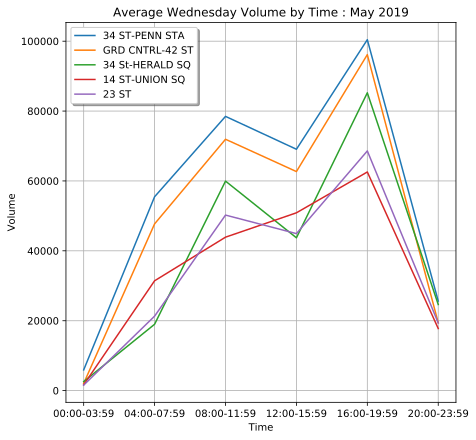

In [94]:
plt.figure(figsize = [7,7])
plt.grid()
plt.plot(mta_34PE_time_Wed['time_cat'],mta_34PE_time_Wed['entries+exits'])
plt.plot(mta_GC42_time_Wed['time_cat'],mta_GC42_time_Wed['entries+exits'])
plt.plot(mta_34HE_time_Wed['time_cat'],mta_34HE_time_Wed['entries+exits'])
plt.plot(mta_14UN_time_Wed['time_cat'],mta_14UN_time_Wed['entries+exits'])
plt.plot(mta_23ST_time_Wed['time_cat'],mta_23ST_time_Wed['entries+exits'])
plt.title("Average Wednesday Volume by Time : May 2019")
plt.legend(["34 ST-PENN STA","GRD CNTRL-42 ST","34 St-HERALD SQ","14 ST-UNION SQ","23 ST"], shadow = True)
plt.ylabel("Volume")
plt.xlabel("Time");

## Graphs

In [107]:
# "34 ST-PENN STA")
#mta_GC42_time_Wed = select_station("GRD CNTRL-42 ST")
#mta_34HE_time_Wed = select_station("34 ST-HERALD SQ")
#mta_14UN_time_Wed = select_station("14 ST-UNION SQ")
#mta_23ST_time_Wed = select_station("23 ST")
# def select_station2(station):
#     new_data = mta19.groupby(['STATION','DDAY','time_cat'])['entries+exits'].mean()
#     new_data = new_data.loc[new_data["STATION"] == station]
#     #new_data = mta_station_day_timeavg[(mta_station_day_timeavg["STATION"] == station) & (mta_station_day_timeavg["DDAY"] == "Wednesday")].sort_values(["DDAY","time_cat","entries+exits"])
#     return new_data

# m1 = select_station2("GRD CNTRL-42 ST")
# m1

# mean_entries_exit = mta19.groupby(['STATION','DDAY','time_cat'])['entries+exits'].mean()
# m = mean_entries_exit['GRD CNTRL-42 ST']
# m1=m.to_frame().reset_index()
# m1.head()


KeyError: 'STATION'